In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

Content from this notebook has been inspired from the fast.ai course-v3 Part 1. In this notebook we'll go through some standard NLP tasks using lessons from fast.ai. We will learn about Transfer Learning in NLP, creating `TextDataBunch` objects, training a model for text classification task, a Sequence2Sequence task and a Sequence Labeling task. We will see how the `fastai` library uses a style called the Data Block API to simplify the process of prepping data for different tasks.

In [56]:
#Google Colab notes: imports for uploading files
#from google.colab import files

In [3]:
path = Path('data')

## Language Modeling

One of the most common tasks done in NLP is called language modeling. A language model is an NLP model which learns to predict the next word in a sentence. We do this is because we assume that if a language model is quite accurate at guessing the next probable word in a sentnce, it needs a lot of world knowledge and a deep understanding of grammar, semantics, and other elements of natural language.

We will show how to train a simple language model.

In [31]:
!wget https://s3.amazonaws.com/text-datasets/nietzsche.txt
!mv nietzsche.txt data

--2019-04-12 08:23:33--  https://s3.amazonaws.com/text-datasets/nietzsche.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.163.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.163.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600901 (587K) [text/plain]
Saving to: ‘nietzsche.txt’

nietzsche.txt       100%[===================>] 586.82K  --.-KB/s    in 0.03s   

2019-04-12 08:23:34 (21.8 MB/s) - ‘nietzsche.txt’ saved [600901/600901]



In [53]:
df = pd.DataFrame(open(path/'nietzsche.txt').read().split('\n'))
df.head()

,0
0,PREFACE
1,
2,
3,SUPPOSING that Truth is a woman--what then? Is...
4,"for suspecting that all philosophers, in so fa..."


In [36]:
data_lm = (TextList.from_df(df,path,cols=[0])
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=bs))

In [38]:
data_lm.show_batch()

idx,text
0,"xxunk methods for \n xxunk a woman ? xxmaj certainly she has never allowed herself to be won ; and \n at present every kind of dogma stands with sad and xxunk xxunk -- xxup if , \n indeed , it stands at all ! xxmaj for there are xxunk who maintain that it \n has fallen , that all dogma lies on the ground --"
1,". xxmaj having kept a sharp eye on philosophers , and having read between \n their lines long enough , i now say to myself that the greater part of \n conscious thinking must be xxunk among the instinctive functions , and \n it is so even in the case of philosophical thinking ; one has here to \n learn anew , as one learned anew"
2,"nature , "" means \n actually the same as "" living according to xxunk could you do \n xxup differently ? xxmaj why should you make a principle out of what you yourselves \n are , and must be ? xxmaj in reality , however , it is quite otherwise with you : \n while you xxunk to read with xxunk the xxunk of your law"
3,"to \n xxmaj german philosophy , it was a delight to the noble xxunk , the virtuous , \n the xxunk , the xxunk , the three - fourths xxmaj christians , and the \n political xxunk of all nations , to find an antidote to the still \n xxunk sensualism which xxunk from the last century into \n this , in xxunk xxunk ."
4,"a \n xxup popular xxup prejudice and exaggerated it . xxmaj willing seems to me to be above \n all something xxup complicated , something that is a unity only in name -- and \n it is precisely in a name that popular prejudice lurks , which has got \n the mastery over the xxunk xxunk of philosophers in all ages . \n xxmaj so"


In [45]:
learn = language_model_learner(data_lm, AWD_LSTM,drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


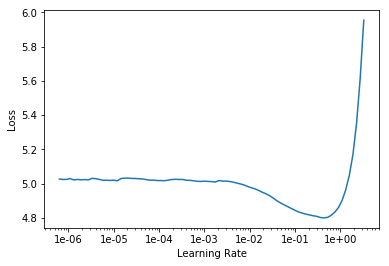

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(1,1e-2,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.739930,4.243732,0.219531,00:02


In [48]:
learn.unfreeze()
learn.fit_one_cycle(4,3e-3,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.246180,3.930275,0.253069,00:03
1,4.047166,3.802835,0.278850,00:03
2,3.777944,3.773712,0.287556,00:03
3,3.528073,3.786354,0.288170,00:03


In [49]:
learn.predict('It is perhaps just dawning on five or six minds',n_words=100)

'It is perhaps just dawning on five or six minds that a faculty of philosophy might \n  be responsible for its development . Even in its most logical position , no \n  goal , no doubt , would always be necessary for the very preservation and very maintenance of \n  itself , depends upon all the general utility , and \n  should be taught to do so . As \n  far as we look upon we obtain , we find it difficult when we learn , are just \n  eager to APPROACH OUR ANTAGONISM are REALLY \n  better -- we want the English'

## Tokenization and Numericalization
The most common preprocessing on NLP tasks in tokenization i.e splitting the sentence into words. This is much easier in space-seperated words like English however, for Japanese we require Morphological Analysis tools to get words from sentences.

Numericalizing in the second preprocessing step. Since models can only take numbers as inputs, we make a dictionary mapping unique words to indices and replace the words with the words in the sentence with their corresponding index. Here we limit our dictionary size to 60000 words that appear at least 3 times in our corpus.

In [54]:
import re
import MeCab

tagger = MeCab.Tagger("-Owakati")

class MeCabTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = 'ja'
    
    def add_special_cases(self, toks:Collection[str]): pass
    
    def tokenizer(self,raw_sentence):
        result = tagger.parse(raw_sentence)
        words = result.split()
        if len(words) == 0:
            return []
        if words[-1] == "\n":
            words = words[:-1]
        return words

## Text Classification
One particular area that was challenging until recently with deep learning for NLP, was text classification.

Similar to classifying images in text we can also use transfer learning to train accurate classifiers with few training examples. We will leverage weights from a language model trained on a large corpus as our pretrained weights. We will fine-tune the language model to our target dataset, attach a classification layer to our model and train by gradual unfreezing. The text classifying task will be sentiment analysis on Yahoo Movie Reviews. The data can be downloaded from this [repository](https://github.com/dennybritz/sentiment-analysis/tree/master/data)

In [55]:
#Google Colab Notes: download data and upload them into your notebook environment
#files.upload()

In [17]:
def load_ymr_data(path):
    with path.open() as f:
        data = pd.read_json(f)
        data.movieName = data.movieName.str.strip()
        data.text = data.text.str.strip()
        data.title = data.title.str.strip()
        data = data[data.text.str.len() > 0]
        data.url = data.url.str.strip()
    return data

def make_polar(data, balance=True):
    data_polar = data.loc[data.rating != 3].copy()
    data_polar.loc[data_polar.rating <= 2, 'rating'] = 0
    data_polar.loc[data_polar.rating >= 4, 'rating'] = 1
    if balance:
        # Subsample - We want the same number of positive and negative examples
        grouped_ratings = data_polar.groupby('rating')
        K = grouped_ratings.rating.count().min()
        indices = itertools.chain(
            *[np.random.choice(v, K, replace=False) for k, v in grouped_ratings.groups.items()])
        data_polar = data_polar.reindex(indices).copy()
    return data_polar


mov_df = load_ymr_data(path/'yahoo-movie-reviews.json')
mov_df_polar = make_polar(mov_df)

In [18]:
mov_df_polar.head()

,date,movieName,movieUrl,rating,text,title,url
85996,2014年8月25日 13時06分,GODZILLA ゴジラ,http://movies.yahoo.co.jp/movie/GODZILLA%E3%80...,0,結論。\nゴジラが出れば、何とかなる的なおそまつなストリー展開。\nオープニングは何となくわ...,がっかり。,http://movies.yahoo.co.jp/movie/GODZILLA%E3%80...
43189,2007年5月5日 21時38分,バベル,http://movies.yahoo.co.jp/movie/%E3%83%90%E3%8...,0,映画自体の内容よりも、ブラピとRINKO KIKUCHIが日本では話題になっていただけの映画...,はっきり言って駄作・・・,http://movies.yahoo.co.jp/movie/%E3%83%90%E3%8...
66294,2015年10月29日 22時16分,心が叫びたがってるんだ。,http://movies.yahoo.co.jp/movie/%E5%BF%83%E3%8...,0,開始5分でこれダメだと思った。とってつけたような安い恋愛模様、酷い下ネタ、歌で誤魔化してる感...,予告と違う,http://movies.yahoo.co.jp/movie/%E5%BF%83%E3%8...
42707,2007年8月10日 15時16分,トランスフォーマー,http://movies.yahoo.co.jp/movie/%E3%83%88%E3%8...,0,ロボット達の変形、戦闘かなり良かったんだけどどうもデザインがいただけない、現代のアメコミ風と...,CGは最高点 だけどね・・・不満いっぱい,http://movies.yahoo.co.jp/movie/%E3%83%88%E3%8...
21297,2011年9月14日 16時29分,コクリコ坂から,http://movies.yahoo.co.jp/movie/%E3%82%B3%E3%8...,0,タイトルとの関連って、気になりますよね。。\n\nでも坂が関係したのは、カレーの肉を買いに駿...,ようやく見てきましたが,http://movies.yahoo.co.jp/movie/%E3%82%B3%E3%8...


In [20]:
tokenizer = Tokenizer(MeCabTokenizer, 'ja')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000,min_freq=2)]

In [22]:
bs=64

In [23]:
data_lm = (TextList.from_df(mov_df_polar,path,cols=['text'],processor=processor)
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch(bs=bs))

In [24]:
data_lm.show_batch()

idx,text
0,、 気合い 入れ て 臨ん だ に も 拘ら ず 筋 の 無い 映画 に がっかり だっ た の で は ？ xxbos 映画 自体 の 内容 より も 、 ブラピ と xxup xxunk xxup xxunk が 日本 で は 話題 に なっ て い た だけ の 映画 でし た 。 観 て い て 不快感 と 沈ん だ 気持ち が 残る し 、 映画 に ぐいぐい 引き込ま れる
1,の 感じ でし た が 、 ４ で xxunk と 思い き xxunk だの 近未来 の 映画 に 変わり すごく 残念 です 。 xxbos 映画 は xxunk 商業 です から 、 「 商業 映画 」 で いい と 考え て い ます 。 が 、 今回 は 残念 と しか 言え ず 、 、 。 正直 「 小栗旬 出し とけ ば 安 パイ 」 が 見え すぎ まし た 。
2,と 登場人物 が 同じ な のに 全然 別物 作品 じゃ ない の ・ ・ ・ ？ うじうじ し て 頼り ない シンジ 、 自信 過剰 だ けど 崩れる と 脆い アスカ 、 それと なに より 無機質 で クール で 無口 な レイ … その 基盤 あっ て の エヴァンゲリオン なん じゃ ない の ？ ！ それ に 今頃 新 キャラ なんて いら ない し 、 アニオタ 萌 ～ な エロい
3,お 粗末 な 状態 だっ た ため 、 後半 から ネタバレ が 延々と 続い た よう な 印象 だっ た 。 もっと 仕草 に 共通点 を 持た せる とか 、 顔 の 代わり に 声 や 背後 、 電話 シーン だけ 写す とか 、 映像 表現 で 如何 よう に も 工夫 でき た はず 。 そういった 工夫 なく 、 ただ ダラダラ と 脚本 の 伏線 を 押さえ た だけ
4,けど 。 神木 が やる と 正直 ちょっと 天然 な 青年 って 見える 。 瀬田宗次郎 って 表情 は いつも ニコニコ し て い て それでも 喜怒哀楽 を 表情 に 出さ ない 青年 。 これ は もう 原作 に しか でき ない 。 後 、 四乃森蒼紫 。 これ は もう 似 てる も 何 も 伊勢谷 さん が あの 衣装 が もう ｗ ｗ 問題 は 志々雄真実 。 原作 を イメージ


We will initialize our model with weights from a language model trained on Japanese Wikipedia. You can download them from here and you need to place the `.pth` file in the `data/models/` directory and `.pkl` file in the `data/models/ja-wiki/` directory.

In [ ]:
#Google colab notes: upload model files
#files.upload()

In [27]:
learn = language_model_learner(data_lm, AWD_LSTM,pretrained_fnames=['ja-wiki','ja-wiki/itos'])

In [28]:
learn.fit_one_cycle(1,1e-2,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [11]:
learn.unfreeze()
learn.fit_one_cycle(10,3e-3,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,2.797721,2.649096,0.585284,10:45
1,2.347854,2.232138,0.625643,10:50
2,2.237379,2.108713,0.637691,10:46
3,2.148961,2.044700,0.643987,10:45
4,2.092854,2.000204,0.648571,10:43
5,2.051646,1.964949,0.652706,10:44
6,2.010329,1.935624,0.656021,10:42
7,1.972503,1.915587,0.658546,10:45
8,1.940315,1.906391,0.659713,10:43


KeyboardInterrupt: 

In [ ]:
learn.save('ymr')
learn.save_encoder('ymr_enc')

In [271]:
data_clas = (TextList.from_df(mov_df_polar,path,cols=['text'],vocab=data_lm.vocab,processor=processor)
                   .split_by_rand_pct(0.1)
                   .label_from_df(cols=['rating'])
                   .databunch(bs=bs))

In [272]:
data_clas.show_batch()

text,target
xxbos ・ 過去 の 行い と 罪 の 意識 から 強 さ の 裏 で 自分 の 命 を 軽 ん じ て い た 剣心 が 、 師匠 と 剣 を 交える うち に 「 死に たく ない ！ 」 「 死ね ない ！ 」 と 強く 思い 、 「 生きよう と する 意思 」 に 目覚め た こと で 本当 の 強 さ を 手 に 入れ 、,0
xxbos 率直 に 、 素直 に ・ ・ この 映画 、 不快 でし た ・ ・ 。 それ と共に 、 友人 から 聞い た 日本人差別 の 話 が 、 頭 に 甦り まし た 。 幼稚園 の xxunk の とき から の 、 xxunk が 、 xxunk の 時 、 お 父様 の 転勤 で 、 アメリカ xxup la に 、 xxunk し まし た 。 その 友人 と は,0
xxbos 「 パッチギ xxup love＆peace 」 で は 、 「 在日 は 被害者 、 日本人 は 悪者 」 という 構図 で 話 が 描か れ て い ます 。 では 、 はたして 実際 にそう だっ た の でしょ う か ？ 現在 の 朝鮮総連 の xxunk 団体 で ある 「 xxunk 」 xxunk は １ ９ ４ ６ 年 初頭 に 「 日本 の 敗戦 で 開放 さ れ た,0
xxbos 私 は 、 「 ガンダム 」 や 、 「 エヴァンゲリオン 」 等 は 、 タイトル を 知っ て いる くらい で 、 ほとんど 、 観 た 事 が ありません な ので 、 初めて 、 本作 の 「 予告 」 を 観 た 時 も 、 鼻 で 笑っ て い まし た 。 <(_ _)> よって 、 その 時点 で は 、 当然 、 xxunk つもり で い た,1
xxbos マーティン・スコセッシ 監督 、 レオナルド・ディカプリオ 主演 の 謎解き ミステリー 。 しかし 、 また し て も 宣伝 は 、 作品 本来 の 魅力 で は なく 、 表面 上 の ミステリー 部分 を xxup ｐｒ し て いる よう で 、 納得 でき ない ところ が あり ます 。 この 作品 は 、 伏線 の 多い ミステリー だ から こそ 、 画面 に 集中 し て もらう ため 、 そして,1


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ymr_enc')

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("映画すごかったよ!")

In [ ]:
learn.predict("演技が悪い")

## Seq2Seq

A sequence-to-sequence model is a model that takes a sequence of items and outputs another sequence of items using two networks that are trained end-to-end. This is perfect for machine translation since input sequences are directly related to output sequences. We will looking at preparing a dataset for Machine Translation task and implementing a seq2seq model. We will be using the parallel corpus available from [here](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz)

In [33]:
def make_corpus(corpus_path):
    corpus = corpus_path.open().readlines()
    data_pair = []
    pat = r'#ID.+\n'
    for c in corpus:
        if 'A: ' in c:
            clean_c = c.replace('A: ','')
            res = re.search(pat,clean_c)
            clean_c = clean_c.replace(res.group(0),'').split('\t')
            data_pair.append((clean_c[0],clean_c[1]))
    return pd.DataFrame(data_pair,columns=['ja','en'])

In [34]:
df = make_corpus(path/'examples.utf')
df.head()

,ja,en
0,ムーリエルは２０歳になりました。,Muiriel is 20 now.
1,すぐに戻ります。,I will be back soon.
2,すぐに諦めて昼寝をするかも知れない。,I may give up soon and just nap instead.
3,愛してる。,I love you.
4,ログアウトするんじゃなかったよ。,I shouldn't have logged off.


In [43]:
len(df)

149784

In [286]:
valid_idxs = np.random.choice(np.arange(len(df)), int(0.1*len(df)),replace=False)
train_idxs = [i for i in np.arange(len(df)) if i not in valid_idxs]
len(train_idxs) + len(valid_idxs)

149784

In [29]:
#collation function and databunch code borrowed from here: 
#https://github.com/ohmeow/seq2seq-pytorch-fastai/blob/master/seq2seq-rnn-attn.ipynb

def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        include_targets=True, include_lengths=False, include_masks=False,
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    samples.sort(key=lambda x: len(x[0]), reverse=True)
    
    x_lens = [len(s[0]) for s in samples]
    x_max_len = max(x_lens)
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    
    y_lens = [len(s[1]) for s in samples]
    y_max_len = max(y_lens)
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    x = [x_res]
    if (include_targets): x += [y_res.clone()]
    if (include_lengths): x += [torch.tensor(x_lens), torch.tensor(y_lens)]
    if (include_masks): x += [x_res != pad_idx, y_res != pad_idx]
    
    return x, y_res


class Seq2SeqDataBunch(DataBunch):

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        
        """Function that transform the `datasets` in a `DataBunch` for seq2seq task. 
        Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [30]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch

In [273]:
en_tok = Tokenizer(lang='en')
en_procs = [TokenizeProcessor(tokenizer=en_tok, include_bos=True, include_eos=True), 
            NumericalizeProcessor(min_freq=1)]

In [274]:
tokenizer = Tokenizer(MeCabTokenizer, 'ja')
ja_procs = [TokenizeProcessor(tokenizer=tokenizer,include_bos=True, include_eos=True), NumericalizeProcessor(max_vocab=30000,min_freq=1)]

In [288]:
en_il = Seq2SeqTextList.from_df(df, path, cols=['en'], processor=en_procs).process().split_by_idxs(train_idxs,valid_idxs)
ja_il = Seq2SeqTextList.from_df(df, path, cols=['ja'], processor=ja_procs).process().split_by_idxs(train_idxs,valid_idxs)

In [289]:
tr_ll = LabelList(en_il.train,ja_il.train)
val_ll = LabelList(en_il.valid,ja_il.valid)
lls = LabelLists(path,train=tr_ll,valid=val_ll)

In [290]:
seq2seq_data = lls.databunch(bs=bs)

In [291]:
seq2seq_data.train_ds[0]

(Text xxbos xxmaj muiriel is 20 now . xxeos,
 Text xxbos ムーリエル は ２ ０ 歳 に なり まし た 。 xxeos)

In [ ]:
en_vecs,_,dim_en_vec = load_vectors('data/wiki-news-300d-1M.vec')
j_vecs,_,dim_j_vec = load_vectors('data/cc.ja.300.vec')

In [277]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    if vecs is None: return emb
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w])
        except: miss.append(w)
    print('Number of unknowns in data: {}'.format(len(miss)))
    return emb


In [278]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [292]:
class Seq2SeqAttention(nn.Module):
    def __init__(self,int2en,int2j,em_sz,j_vecs=None,en_vecs=None,nh=128,out_sl=25,dropf=1,nl=2):
        super().__init__()
        #encoder
        self.nl,self.nh,self.em_sz,self.out_sl = nl,nh,em_sz,out_sl
        self.emb_enc = create_emb(en_vecs,int2en,em_sz)
        self.emb_drop = nn.Dropout(0.15*dropf)
        self.encoder = nn.GRU(em_sz,nh,num_layers=nl,dropout=0.25*dropf, bidirectional=True,batch_first=True)
        #decoder
        self.emb_dec = create_emb(j_vecs,int2j,em_sz)
        self.decoder = nn.GRU(em_sz,nh*2,num_layers=nl,dropout=0.25*dropf,batch_first=True)
        self.out_drop = nn.Dropout(0.35*dropf)
        self.out = nn.Linear(nh*2,len(int2j))
        #attention layer
        self.W1 = rand_p(nh*2, nh*2) #parameter
        self.l2 = nn.Linear(nh*2, nh*2)
        self.l3 = nn.Linear(em_sz+nh*2, em_sz)
        self.V = rand_p(nh*2) #parameter
        self.targets = None
    
    def forward(self,inp,y=None):
        self.targets = y
        bs,sl = inp.size()
        emb_in = self.emb_drop(self.emb_enc(inp))
        h_n = self.initHidden(bs)
        enc_out, h_n = self.encoder(emb_in,h_n)
        h_n = h_n.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        dec_inp = torch.zeros(bs).long().cuda()
        res,attns = [], []
        #multiply by parameter
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            #linear layer 
            w2h = self.l2(h_n[-1])
            #non-linear activation to calculate score
            u = torch.tanh(w1e + w2h.unsqueeze(1))
            #softmax to make them into probs
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            #multiply each vector by scores and then add them up
            Xa = (a.unsqueeze(2) * enc_out).sum(1)
            dec_emb = self.emb_dec(dec_inp)
            #linear layer to reduce dimensions
            wgt_enc = self.l3(torch.cat([dec_emb, Xa], 1))
            outp,h_n = self.decoder(wgt_enc.unsqueeze(1),h_n)
            outp = self.out(self.out_drop(outp[:,0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if i >=self.targets.size(1):break
            if (dec_inp==1).all(): break
            if (random.random() > 0.5) and self.targets is not None: dec_inp=y[:,i] 
        return torch.stack(res).transpose(1,0)
        
    def initHidden(self,bs):
        return torch.zeros([self.nl*2,bs,self.nh]).cuda()

In [293]:
def seq2seq_loss(input, target):
    bs,sl = target.size()
    bs_in,sl_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,sl-sl_in,0,0))
    input = input[:,:sl,:]
    return F.cross_entropy(input.contiguous().view(-1,nc), target.contiguous().view(-1))

In [294]:
class TeacherForcingCallback(LearnerCallback):
    learn:Learner
        
    def on_batch_begin(self, train, **kwargs):
        learn.model.targets = kwargs['last_target']

In [295]:
seq2seq = Seq2SeqAttention(seq2seq_data.train_ds.x.vocab.itos,seq2seq_data.train_ds.y.vocab.itos,300,en_vecs=None,j_vecs=None)
seq2seq.cuda()

Seq2SeqAttention(
  (emb_enc): Embedding(21395, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (encoder): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (emb_dec): Embedding(30004, 300, padding_idx=1)
  (decoder): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=256, out_features=30004, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=556, out_features=300, bias=True)
)

In [296]:
learn = Learner(seq2seq_data,seq2seq)
learn.loss_func = seq2seq_loss

In [297]:
learn.callbacks.append(TeacherForcingCallback(learn))

In [254]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


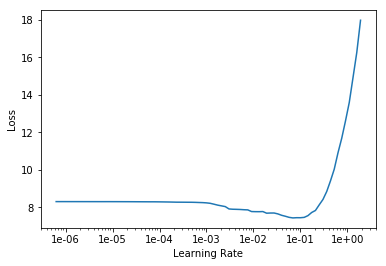

In [255]:
learn.recorder.plot()

In [298]:
learn.fit_one_cycle(5, 3e-3, moms=(0.7,0.8))

epoch,train_loss,valid_loss,time
0,3.339883,2.918007,03:46
1,2.839581,2.631924,03:53


KeyboardInterrupt: 

## Sequence Labeling